In [5]:
%pylab inline
from tempfile import gettempdir
from pathlib import Path
from bs4 import BeautifulSoup
from scipy import stats

import numpy as np
import csv
import kaggle.api as kaggle
import pandas as pd
import re
import nltk
import seaborn as sns
import eli5

nltk.download('punkt')

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to /home/anderson/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data

## Download Data

In [6]:
imdb_download_path = Path(gettempdir()) / 'imdb'
imdb_path = imdb_download_path / 'imdb_master.csv'

print(imdb_path)
kaggle.authenticate()
kaggle.dataset_download_files('utathya/imdb-review-dataset', imdb_download_path, unzip=True)

/tmp/imdb/imdb_master.csv


## Read the downloaded data

In [7]:
data = pd.read_csv(imdb_path, delimiter=',', quoting=csv.QUOTE_ALL, encoding='iso-8859-1', index_col=0)

# Remove unsupervised data
data = data[data['label'] != 'unsup']
data['label'] = data['label'].astype('category')
train_data = data[data['type'] == 'train'].drop(['type', 'file'], axis=1)
test_data = data[data['type'] == 'test'].drop(['type', 'file'], axis=1)

print('train_data:', train_data.shape)
print('test_data :', test_data.shape)
display(data.groupby('label').count())
train_data.head()

train_data: (25000, 2)
test_data : (25000, 2)


,type,review,file
label,,,
neg,25000,25000,25000
pos,25000,25000,25000


,review,label
25000,Story of a man who has unnatural feelings for ...,neg
25001,Airport '77 starts as a brand new luxury 747 p...,neg
25002,This film lacked something I couldn't put my f...,neg
25003,"Sorry everyone,,, I know this is supposed to b...",neg
25004,When I was little my parents took me along to ...,neg


# Text Preprocessing

In [8]:
stemmer = nltk.stem.SnowballStemmer('english')
def preprocessing(text):
    review = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove non-letters
    review = re.sub("[^a-zA-Z]", " ", review)
    
    # Lower case
    review = review.lower()
    
    # Tokenize to each word
    token = nltk.word_tokenize(review)
    
    # Stemming 
    review = [stemmer.stem(word) for word in token]
    return ' '.join(review)

train_data['review'] = train_data['review'].apply(preprocessing)
test_data['review'] = test_data['review'].apply(preprocessing)

# TF-IDF & Split

TF-IDF (Term Frequency - Inverse Document Frequency) 는 다음과 같은 특징을 갖고 있습니다.

 - 일반적으로 여러 문서에 걸쳐서 많이 나오는 평범한 단어는 weight를 낮춤 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

tiv = TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True, max_features=40000)

x_train = tiv.fit_transform(train_data['review'])
y_train = train_data['label'].cat.codes

x_test = tiv.transform(test_data['review'])
y_test = test_data['label'].cat.codes

vocab = tiv.get_feature_names()

print('vocab:', len(vocab), vocab[:5])
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

vocab: 40000 ['aaron', 'abandon', 'abandon the', 'abbi', 'abbot']
x_train: (25000, 40000)
y_train: (25000,)
x_test: (25000, 40000)
y_test: (25000,)


In [ ]:
vocab_dist = np.sum(x_train, axis=0)
pd.DataFrame(vocab_dist, columns=vocab).sort_values(0, axis=1)

# Distribution

정규분포에(검은색선) 비해서 실제 분포도는 왼쪽으로 치우쳐져 있는 형태를 갖고 있습니다.<br>
따라서 데이터를 측정하는 단위로 평균 보다는 중위값을 쓰는것이 조금더 좋습니다. <br>
이유는 skewed data이기 때문에 outlier에 평균값이 취약하기 때문입니다. 

- 리뷰당 사용된 단어의 중위값은 177개, <br>
- 리뷰당 사용단 유니크 단어의 중위값은 113개

정도로 요약할수 있습니다. 


In [36]:
train_data['word_cnt'] = train_data['review'].apply(lambda x: len(str(x).split())) # 단어의 갯수
train_data['uniq_cnt'] = train_data['review'].apply(lambda x: len(set(str(x).split()))) # 단어의 갯수

test_data['word_cnt'] = test_data['review'].apply(lambda x: len(str(x).split())) # 단어의 갯수
test_data['uniq_cnt'] = test_data['review'].apply(lambda x: len(set(str(x).split()))) # 단어의 갯수

[Train] Median of the word frequency: 177.0
[Train] Median of the unique word frequency: 112.0
[Test] Median of the word frequency: 174.0
[Test] Median of the unique word frequency: 111.0


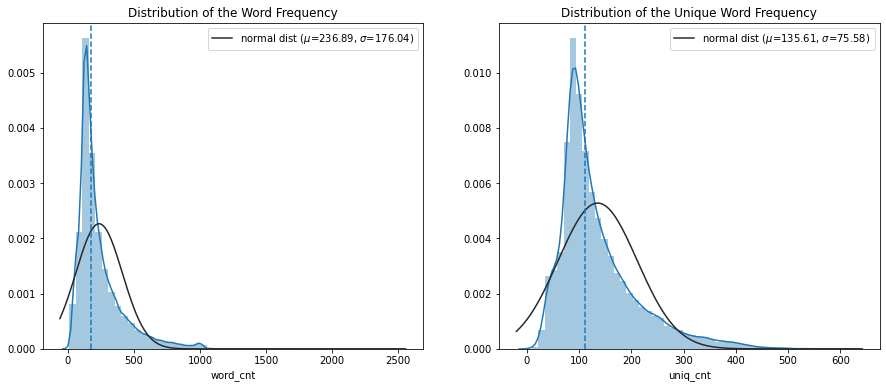

In [37]:
fig, axes = subplots(ncols=2, figsize=(15, 6))

sns.distplot(train_data['word_cnt'], bins=50, ax=axes[0], fit=stats.norm)
mu0, sigma0 = stats.norm.fit(train_data['word_cnt'])
axes[0].legend([f'normal dist ($\mu$={mu0:.2f}, $\sigma$={sigma0:.2f})'])
axes[0].set_title('Distribution of the Word Frequency')
axes[0].axvline(train_data['word_cnt'].median(), linestyle='dashed')

sns.distplot(train_data['uniq_cnt'], bins=50, ax=axes[1], fit=stats.norm)
mu1, sigma1 = stats.norm.fit(train_data['uniq_cnt'])
axes[1].legend([f'normal dist ($\mu$={mu1:.2f}, $\sigma$={sigma1:.2f})'])
axes[1].set_title('Distribution of the Unique Word Frequency')
axes[1].axvline(train_data['uniq_cnt'].median(), linestyle='dashed')

print('[Train] Median of the word frequency:', train_data['word_cnt'].median())
print('[Train] Median of the unique word frequency:', train_data['uniq_cnt'].median())

print('[Test] Median of the word frequency:', test_data['word_cnt'].median())
print('[Test] Median of the unique word frequency:', test_data['uniq_cnt'].median())

# Models

## Linear Support Vector Classification

In [123]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, f1_score


model = LinearSVC(random_state=125)

param_grid = {
    'loss':['squared_hinge'],
    'class_weight':[{1:4}, {1:1}],
    'C': [0.2]
}

kfold = StratifiedKFold(n_splits = 5, random_state=125, shuffle=True)
gs = GridSearchCV(model, param_grid=[param_grid], cv=kfold, n_jobs=4, scoring='roc_auc', verbose=1)
gs.fit(x_train, y_train)

model = gs.best_estimator_
y_pred = model.predict(x_test)

print('gridsearch.best_score_ :', gs.best_score_)
print('gridsearch.best_params_:', gs.best_params_)
print('acc:', accuracy_score(y_test, y_pred))
print('f1 :', f1_score(y_test, y_pred))
eli5.show_weights(model, top=30, target_names=['neg', 'pos'], vec=tiv)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.9s finished


gridsearch.best_score_ : 0.9656695679999998
gridsearch.best_params_: {'C': 0.2, 'class_weight': {1: 1}, 'loss': 'squared_hinge'}
acc: 0.9036
f1 : 0.9040910538045208


## Bernoulli Naive Bayes Classifier

In [126]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()
gs = GridSearchCV(model,
                  param_grid={'alpha': [1., 0.1, 0.01, 0.001],
                              'binarize': [0.01, 0.001, 0.]},
                  verbose=1,
                  cv=kfold,
                  n_jobs=4,
                  scoring="roc_auc")
gs.fit(x_train, y_train)

model = gs.best_estimator_
y_pred = model.predict(x_test)

print('gridsearch.best_score_ :', gs.best_score_)
print('gridsearch.best_params_:', gs.best_params_)
print('acc:', accuracy_score(y_test, y_pred))
print('f1 :', f1_score(y_test, y_pred))
eli5.show_weights(model, top=30, target_names=['neg', 'pos'], vec=tiv)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s


gridsearch.best_score_ : 0.940948656
gridsearch.best_params_: {'alpha': 0.001, 'binarize': 0.001}
acc: 0.8698
f1 : 0.8704168159560493


[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    4.4s finished


In [127]:
eli5.show_weights(model, top=30, target_names=['neg', 'pos'], vec=tiv)

## Perceptron

In [128]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=215)
param_grid = {
    'hidden_layer_sizes':[(5)],
    'activation':['relu'],
    'solver':['adam'],
    'alpha':[0.3],
    'learning_rate':['constant', 0.001, 0.001],
    'max_iter':[1000]
}
gs = GridSearchCV(model, param_grid=param_grid, 
                  cv=kfold, scoring='roc_auc', n_jobs=6, verbose=1)
gs.fit(x_train, y_train)

model = gs.best_estimator_
y_pred = model.predict(x_test)

print('gridsearch.best_score_ :', gs.best_score_)
print('gridsearch.best_params_:', gs.best_params_)
print('acc:', accuracy_score(y_test, y_pred))
print('f1 :', f1_score(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  5.3min finished


gridsearch.best_score_ : 0.965828048
gridsearch.best_params_: {'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
acc: 0.9032
f1 : 0.9035010766408804


## Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=215)

param_grid = {
    'penalty': ['l2'],
    'dual': [False],
    'C': [6, 3, 1, 0.5],
    'class_weight': [{1: 1}]
}

gs = GridSearchCV(model, param_grid=[param_grid],
                     cv=kfold, scoring='roc_auc', n_jobs=1, verbose=1)
gs.fit(x_train, y_train)

model = gs.best_estimator_
y_pred = model.predict(x_test)

print('gridsearch.best_score_ :', gs.best_score_)
print('gridsearch.best_params_:', gs.best_params_)
print('acc:', accuracy_score(y_test, y_pred))
print('f1 :', f1_score(y_test, y_pred))
eli5.show_weights(model, top=30, target_names=['negative', 'positive'], vec=tiv)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


gridsearch.best_score_ : 0.965819424
gridsearch.best_params_: {'C': 6, 'class_weight': {1: 1}, 'dual': False, 'penalty': 'l2'}
acc: 0.90324
f1 : 0.9035524899326183
